In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# 株式データの取得
ticker = 'AAPL'  # 例: Appleのティッカーシンボル
data = yf.download(ticker, start='2015-01-01', end='2021-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
# 移動平均 (20日と50日)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

In [4]:
# ボラティリティ (過去20日間の標準偏差)
data['Volatility'] = data['Close'].rolling(window=20).std()

In [5]:
# RSI (相対力指数)
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

In [6]:
# 特徴量とラベルの作成
# ラベルは翌日の株価が上昇するか下降するか
data['Price_Up'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)


In [7]:
# 必要な列だけを選択
features = ['SMA_20', 'SMA_50', 'Volatility', 'RSI']
data = data.dropna()  # 欠損値を削除


In [8]:
X = data[features]
y = data['Price_Up']

In [9]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# ロジスティック回帰モデル
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [11]:
# 予測
y_pred = model.predict(X_test)

In [12]:

# 結果の評価
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4812286689419795
              precision    recall  f1-score   support

           0       0.38      0.14      0.21       139
           1       0.50      0.79      0.61       154

    accuracy                           0.48       293
   macro avg       0.44      0.46      0.41       293
weighted avg       0.44      0.48      0.42       293



In [13]:
# 予測結果をデータフレームに追加して表示
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

            Actual  Predicted
Date                         
2018-09-27       1          1
2019-08-06       1          1
2016-11-01       1          0
2017-04-10       0          1
2019-04-26       1          1


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [15]:
# ROC曲線のプロット
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)


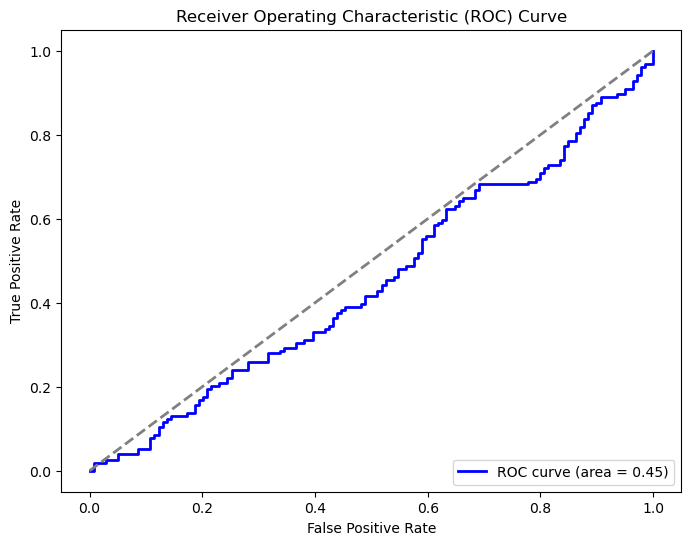

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()